<a href="https://colab.research.google.com/github/andrei-radulescu-banu/stat453-deep-learning-ss21/blob/main/L15/1_lstm_torch_1.13.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U torch==1.13.0 torchtext==0.14.0 torchdata==0.5.0

# Reload environment
exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 18.1 MB/s 
     |████████████████████████████████| 140 kB 24.2 MB/s 
     |████████████████████████████████| 127 kB 53.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Derived from:
STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Lecture 15: Introduction to recurrent neural networks

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21  
Andrei's fork: https://github.com/andrei-radulescu-banu/stat453-deep-learning-ss21

Ported by Andrei R-B to torchtext 0.14.0, using new DataPipes.

---

In [2]:
!pip install watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 34.8 MB/s 


# RNN Classifier with LSTM Trained on Own Dataset (IMDB)

Example notebook showing how to use an own CSV text dataset for training a simple RNN for sentiment classification (here: a binary classification problem with two labels, positive and negative) using LSTM (Long Short Term Memory) cells.

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka, Andrei R-B' -v -p torch,torchtext

import torch
import torch.nn.functional as F
import torchtext
import time
import random
import numpy as np
import pandas as pd

torch.backends.cudnn.deterministic = True

Author: Sebastian Raschka, Andrei R-B

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 7.9.0

torch    : 1.13.0+cu116
torchtext: 0.14.0



## General Settings

In [2]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.005
BATCH_SIZE = 128
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2

## Download Dataset

The following cells will download the IMDB movie review dataset (http://ai.stanford.edu/~amaas/data/sentiment/) for positive-negative sentiment classification in as CSV-formatted file:

In [3]:
!wget https://github.com/rasbt/python-machine-learning-book-3rd-edition/raw/master/ch08/movie_data.csv.gz

--2022-12-10 23:50:02--  https://github.com/rasbt/python-machine-learning-book-3rd-edition/raw/master/ch08/movie_data.csv.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch08/movie_data.csv.gz [following]
--2022-12-10 23:50:03--  https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch08/movie_data.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26521894 (25M) [application/octet-stream]
Saving to: ‘movie_data.csv.gz’

movie_data.csv.gz   100%[===================>]  25.29M   152MB/s    in 0.2s   

In [4]:
!gunzip -f movie_data.csv.gz 

Check that the dataset looks okay:

In [5]:
df = pd.read_csv('movie_data.csv')
df.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [6]:
del df

## Prepare Dataset with Torchdata and the new DataPipes API

In [7]:
from torchdata.datapipes.iter import IterableWrapper, FileOpener
datapipe = IterableWrapper(["movie_data.csv"])
datapipe = FileOpener(datapipe, mode='b')
datapipe = datapipe.parse_csv(skip_lines=1)

for sample in datapipe:
     print(sample)
     break

['In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich fami

## Split Dataset into Train/Validation/Test

Split the dataset into training, validation, and test partitions:

In [8]:
# Get the number of rows in dataset
N_ROWS = len(list(datapipe))  # 50000

# Split into training and val datapipes early on. Will build vocabulary from training datapipe only.
train_dp, valid_dp, test_dp = datapipe.random_split(total_length=N_ROWS, weights={"train": 0.8, "valid": 0.1, "test": 0.1}, seed=0)

print(f'Num Train: {len(train_dp)}')
print(f'Num Validate: {len(valid_dp)}')
print(f'Num Test: {len(test_dp)}')

Num Train: 40000
Num Validate: 5000
Num Test: 5000


## Build the Vocabulary

Build the vocabulary based on the top `VOCABULARY_SIZE` words. **build_vocab_from_iterator()** collects the most frequent tokens from the iterator **yield_tokens(train_datapipe)**, and adds special tokens at the begginning w/o changing the order of supplied tokens.


In [9]:
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

# See tutorial at https://www.youtube.com/watch?v=CrS-LFXEiyk
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

def get_vocab(train_datapipe):
    vocab = build_vocab_from_iterator(yield_tokens(train_datapipe), specials=["<UNK>", "<PAD>"], max_tokens=VOCABULARY_SIZE)
    vocab.set_default_index(vocab["<UNK>"])
    return vocab

**Build the vocabulary**

In [10]:
vocab = get_vocab(train_dp)
print("Vocabulary size: ", len(vocab))

Vocabulary size:  20000


**Tokens corresponding to the first 10 indices (0, 1, ..., 9):**

In [11]:
print(vocab.get_itos()[:10]) # itos = integer-to-string

['<UNK>', '<PAD>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'"]


PyTorch RNNs can deal with arbitrary lengths due to dynamic graphs, but padding is necessary for padding sequences to the same length in a given minibatch so we can store those in an array.

**Converting a string to an integer:**

In [12]:
# A direct way
print(f"the: {vocab['the']}")

# And an indirect way, using get_stoi() to get a dictionary of tokens and values
print(f"the: {vocab.get_stoi()['the']}") # stoi = string-to-integer

# What is the padding value?
print(f"<PAD>: {vocab['<PAD>']}")
PADDING_VALUE=vocab['<PAD>']

the: 2
the: 2
<PAD>: 1


**How are unknown tokens handled?**

In [13]:
print(f"Default index: {vocab.get_default_index()}")

# Value of unknown token is default index when referenced with [] brackets:
vocab['123aaa']

Default index: 0


0

Both `text_transform` and `label_transform` are the callable object, such as a lambda func here, to process the raw text and label data from the dataset iterators.

In [14]:
text_transform = lambda x: [vocab[token] for token in tokenizer(x)]
label_transform = lambda x: 1 if x == '1' else 0

# Print out the output of text_transform
print("input to the text_transform:", "here is an example")
print("output of the text_transform:", text_transform("here is an example"))

input to the text_transform: here is an example
output of the text_transform: [135, 10, 41, 476]


**How do I convert an array of integers to the corresponding tokens?**

In [15]:
vocab_itos = vocab.get_itos()
vec_vocab_itos = np.vectorize(lambda x: vocab_itos[x])
vec_vocab_itos([1, 2, 3, 4, 5])

array(['<PAD>', 'the', '.', ',', 'and'], dtype='<U5')

## Define Data Loaders

`torch.utils.data.DataLoader` is used to generate data batch. Users could customize the data batch by defining a function with the `collate_fn` argument in the DataLoader. Here, in the `collate_batch` func, we process the raw text data and add padding to dynamically match the longest sentence in a batch.

In [16]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_batch(batch):
   text_list, label_list = [], []
   for (_text, _label) in batch:
        label_list.append(label_transform(_label))
        processed_text = torch.tensor(text_transform(_text))
        text_list.append(processed_text)
   return pad_sequence(text_list, padding_value=PADDING_VALUE).to(DEVICE), torch.tensor(label_list).to(DEVICE)

train_loader = DataLoader(list(train_dp), batch_size=BATCH_SIZE, shuffle=True, 
                          collate_fn=collate_batch)
valid_loader = DataLoader(list(valid_dp), batch_size=BATCH_SIZE, shuffle=True, 
                          collate_fn=collate_batch)
test_loader = DataLoader(list(test_dp), batch_size=BATCH_SIZE, shuffle=True, 
                         collate_fn=collate_batch)


text_batch, label_batch = next(iter(train_loader))
print(text_batch.size())
print(label_batch.size())

torch.Size([1210, 128])
torch.Size([128])


Testing the iterators (note that the number of rows depends on the longest document in the respective batch):

In [17]:
print('Train')
for text_batch, label_batch in train_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break
    
print('\nValid:')
for text_batch, label_batch in valid_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break
    
print('\nTest:')
for text_batch, label_batch in test_loader:
    print(f'Text matrix size: {text_batch.size()}')
    print(f'Target vector size: {label_batch.size()}')
    break

Train
Text matrix size: torch.Size([1152, 128])
Target vector size: torch.Size([128])

Valid:
Text matrix size: torch.Size([1103, 128])
Target vector size: torch.Size([128])

Test:
Text matrix size: torch.Size([855, 128])
Target vector size: torch.Size([128])


**The text batch as indices of tokens**

In [18]:
print(text_batch)

tensor([[  14, 6989,   13,  ...,    2,   13,   13],
        [  17, 4518,  429,  ...,   23,    9,   48],
        [   6,   67,    8,  ..., 3821,  151, 1204],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')


**The corresponding vocabulary tokens**

Notice how the reviews appear on the tensor columns. Each column has one review.

In [19]:
print(vec_vocab_itos(text_batch.to("cpu")))

[['this' 'hercules' 'i' ... 'the' 'i' 'i']
 ['was' 'wound' 'went' ... 'film' "'" 'just']
 ['a' 'up' 'to' ... 'listed' 'm' 'bought']
 ...
 ['<PAD>' '<PAD>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>']
 ['<PAD>' '<PAD>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>']
 ['<PAD>' '<PAD>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>']]


**And the batch labels**

Each element is the review score for the corresponding column.

In [20]:
print(label_batch)

tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')


**The next batch will have different text column size.**

The column size is determined by the max length of reviews in a batch. Each batch has a different text column size.

In [21]:
text_batch, label_batch = next(iter(train_loader))
print(f'Text matrix size: {text_batch.size()}')
print(f'Target vector size: {label_batch.size()}')

text_batch, label_batch = next(iter(train_loader))
print(f'Text matrix size: {text_batch.size()}')
print(f'Target vector size: {label_batch.size()}')

Text matrix size: torch.Size([1026, 128])
Target vector size: torch.Size([128])
Text matrix size: torch.Size([1107, 128])
Target vector size: torch.Size([128])


To group the texts with similar length together, like introduced in the legacy `BucketIterator` class, first of all, we randomly create multiple "pools", and each of them has a size of `batch_size * 100`. Then, we sort the samples within the individual pool by length. This idea can be implemented succintly through `batch_sampler` argument of PyTorch `Dataloader`. `batch_sampler` accepts 'Sampler' or Iterable object that yields indices of next batch. In the code below, we implemented a generator that yields batch of indices for which the corresponding batch of data is of similar length. 

In [22]:
train_list = list(train_dp)

def batch_sampler():
    indices = [(i, len(tokenizer(s[0]))) for i, s in enumerate(train_list)]
    random.shuffle(indices)
    pooled_indices = []
    # create pool of indices with similar lengths 
    for i in range(0, len(indices), BATCH_SIZE * 100): 
       pooled_indices.extend(sorted(indices[i:i + BATCH_SIZE * 100], key=lambda x: x[0]))

    pooled_indices = [x[1] for x in pooled_indices]

    # yield indices for current batch
    for i in range(0, len(pooled_indices), BATCH_SIZE):
        yield pooled_indices[i:i + BATCH_SIZE]

train_loader1 = DataLoader(train_list, batch_sampler=batch_sampler(),
                           collate_fn=collate_batch)

text_batch, label_batch = next(iter(train_loader1))
print(text_batch.size())
print(label_batch.size())

torch.Size([1331, 128])
torch.Size([128])


In [23]:
print(vec_vocab_itos(text_batch.to("cpu")))

[['the' 'still' 'this' ... 'on' 'north' 'a']
 ['animation' 'crazy' 'is' ... 'rare' 'and' 'longtime']
 ['quality' 'is' 'the' ... 'occasions' 'south' 'fan']
 ...
 ['<PAD>' '<PAD>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>']
 ['<PAD>' '<PAD>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>']
 ['<PAD>' '<PAD>' '<PAD>' ... '<PAD>' '<PAD>' '<PAD>']]


In [24]:
print(label_batch)

tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')


## Utility Functions

**Compute model accuracy on a dataloader**

Pass the train, valid or test dataloader


In [25]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

**Train a model**

This is model- and dataloader-independent.

In [26]:
def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc'):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')
        
        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')
        

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list


**Plot training loss and accuracy**

In [27]:
import matplotlib.pyplot as plt

def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)


## Model

In [28]:
class LSTM(torch.nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        #self.rnn = torch.nn.RNN(embedding_dim,
        #                        hidden_dim,
        #                        nonlinearity='relu')
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)        
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, text):
        # text dim: [sentence length, batch size]        
        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]
        
        output = self.fc(hidden)
        return output

## Train and plot the results

In [29]:
model = LSTM(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES # could use 1 for binary classification
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)



Epoch: 001/015 | Batch 0000/0313 | Loss: 0.6936
Epoch: 001/015 | Batch 0100/0313 | Loss: 0.6931
Epoch: 001/015 | Batch 0200/0313 | Loss: 0.6933
Epoch: 001/015 | Batch 0300/0313 | Loss: 0.6935
Epoch: 001/015 | Train: 50.03% | Validation: 49.60%
Time elapsed: 1.25 min
Epoch: 002/015 | Batch 0000/0313 | Loss: 0.6935
Epoch: 002/015 | Batch 0100/0313 | Loss: 0.6914
Epoch: 002/015 | Batch 0200/0313 | Loss: 0.6912
Epoch: 002/015 | Batch 0300/0313 | Loss: 0.6913
Epoch: 002/015 | Train: 50.13% | Validation: 49.80%
Time elapsed: 2.45 min
Epoch: 003/015 | Batch 0000/0313 | Loss: 0.6883
Epoch: 003/015 | Batch 0100/0313 | Loss: 0.6931
Epoch: 003/015 | Batch 0200/0313 | Loss: 0.6893
Epoch: 003/015 | Batch 0300/0313 | Loss: 0.6903
Epoch: 003/015 | Train: 50.21% | Validation: 50.34%
Time elapsed: 3.67 min
Epoch: 004/015 | Batch 0000/0313 | Loss: 0.6917
Epoch: 004/015 | Batch 0100/0313 | Loss: 0.6889
Epoch: 004/015 | Batch 0200/0313 | Loss: 0.6896
Epoch: 004/015 | Batch 0300/0313 | Loss: 0.6908
Epoch: 

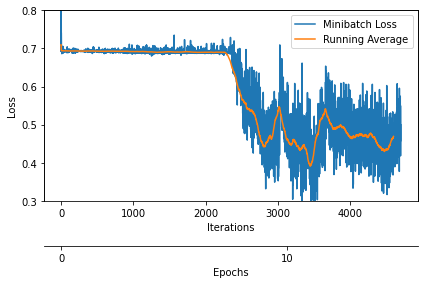

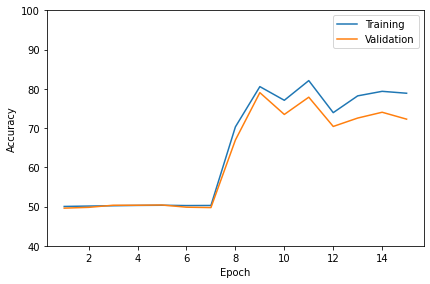

In [35]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)
plt.ylim([0.3, 0.8])
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([40, 100])
plt.show()

In [31]:
def predict_sentiment(model, sentence):

    model.eval()
    tokenized = tokenizer(sentence)
    indexed = [vocab[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(DEVICE)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = F.softmax(model(tensor), dim=1)
    return prediction.to("cpu").squeeze(dim=0).detach().numpy()

print('Probability positive:')
predict_sentiment(model, "This is such an awesome movie, I really love it!")[1]


Probability positive:


0.8943265

In [32]:
print('Probability negative:')
predict_sentiment(model, "I really hate this movie. It is really bad and sucks!")[0]

Probability negative:


0.99055

In [33]:
%watermark -iv

torchtext : 0.14.0
torch     : 1.13.0+cu116
matplotlib: 3.2.2
numpy     : 1.21.6
pandas    : 1.3.5

